# Real tensor to Fourier domain with Hermitian symmetry

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from functools import partial

%matplotlib inline
%load_ext autoreload 
%autoreload 2

In [2]:
size = jnp.array(3*[6])
n_rep = int(1e6)
spatial = jr.normal(jr.key(0), (n_rep,*size))
# spatial /= size.prod()**.5
i_toplot = 0

def plot_fourier(fourier, i_toplot=0):
    n_rep, *size = fourier.shape
    plt.figure(figsize=(7,3))
    plt.subplot(121)
    plt.pcolormesh(fourier.real[0,:,:,i_toplot])
    plt.title("real")
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(fourier.imag[0,:,:,i_toplot])
    plt.title("imag")
    plt.colorbar();
    print("shape:",fourier.shape)
    print("n_unique comp: ", jnp.unique(fourier[0]).shape)
    print("n_unique real: ", jnp.unique(fourier.real[0]).shape)
    print("n_unique imag: ", jnp.unique(jnp.abs(fourier.imag)[0]).shape)
    print("n_unique total: ", jnp.unique(fourier.real[0]).shape[0] + jnp.unique(jnp.abs(fourier.imag)[0]).shape[0], 
          "vs.", size[0]*size[1]*(2*(size[2]-1)), "+1 because of zero")

    all, rea, ima = (jnp.abs(fourier)**2).mean(0), (fourier.real**2).mean(0), (fourier.imag**2).mean(0)
    plt.figure(figsize=(10,6))
    plt.subplot(231)
    plt.pcolormesh(all[:,:,i_toplot])
    plt.title("var abs")
    plt.colorbar()
    plt.subplot(232)
    plt.pcolormesh(rea[:,:,i_toplot])
    plt.title("var real")
    plt.colorbar()
    plt.subplot(233)
    plt.pcolormesh(ima[:,:,i_toplot])
    plt.title("var imag")
    plt.colorbar()

    j_toplot = 3
    C_abs = jnp.cov(jnp.abs(fourier)[:,j_toplot,:,0].T, jnp.abs(fourier)[:,:,j_toplot,0].T)
    C_real = jnp.cov(fourier.real[:,j_toplot,:,0].T, fourier.real[:,:,j_toplot,0].T)
    C_imag = jnp.cov(fourier.imag[:,j_toplot,:,0].T, fourier.imag[:,:,j_toplot,0].T)

    fourier = fourier.reshape(n_rep, -1)
    C_abs = jnp.cov(jnp.abs(fourier).T, jnp.abs(fourier).T)
    C_real = jnp.cov(fourier.real.T, fourier.real.T)
    C_imag = jnp.cov(fourier.imag.T, fourier.imag.T)
    plt.subplot(234)
    plt.imshow(C_abs)
    plt.title("cov abs")
    plt.colorbar()
    plt.subplot(235)
    plt.imshow(C_real)
    plt.title("cov real")
    plt.colorbar()
    plt.subplot(236)
    plt.imshow(C_imag)
    plt.title("cov imag")
    plt.colorbar()
    plt.tight_layout()
    return C_abs, C_real, C_imag

2024-12-11 13:59:14.702187: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


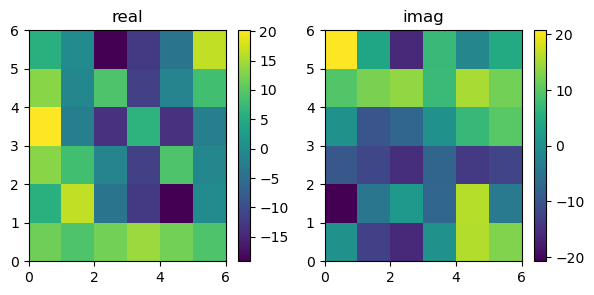

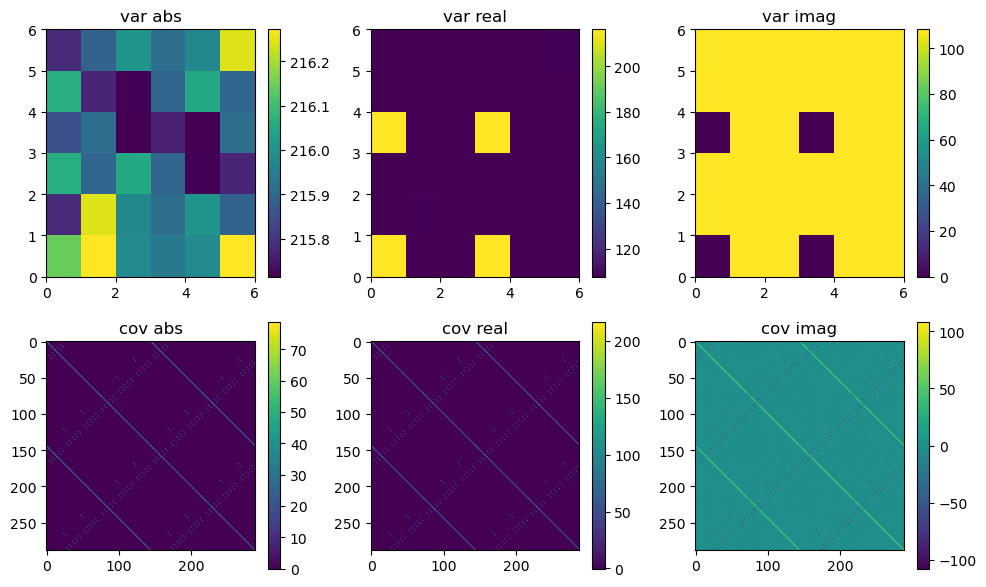

In [3]:
# fourier = vmap(partial(jnp.fft.rfftn, norm="ortho"))(spatial)
fourier = vmap(jnp.fft.rfftn)(spatial)
Cs_rfftn = plot_fourier(fourier, i_toplot)

shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


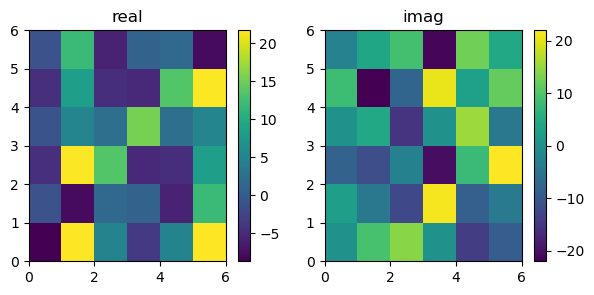

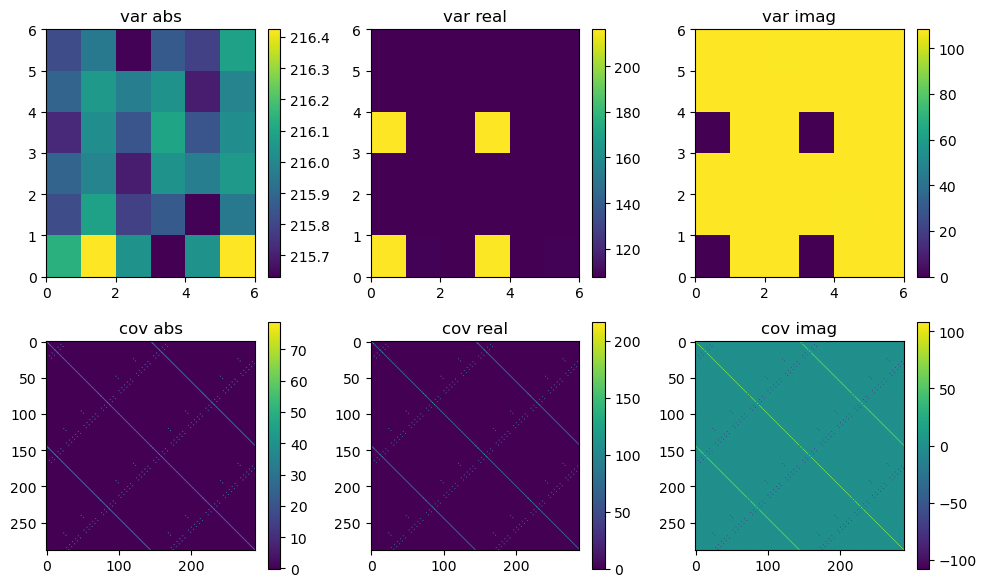

In [4]:
from montecosmo.utils import rg2cgh, cgh2rg
fourier = vmap(rg2cgh)(spatial)
spatial2 = vmap(cgh2rg)(fourier)
from numpy.testing import assert_allclose
assert_allclose(spatial, spatial2, rtol=1e-3)
Cs_rg2cgh = plot_fourier(fourier, i_toplot)
assert_allclose(Cs_rfftn, Cs_rg2cgh, rtol=1e-5, atol=1)

In [5]:
import math

@jit
def genrete_realx_gaussian_field_3d_k_mask(randns, dtype=jnp.float64, cdtype=jnp.complex128):
    """
    randns is an array with nc^3 standard normal vars
    """
    #import numpy as jnp    # change to jax after! fixme
    
    randns = randns.flatten()
    nc = round(randns.shape[0]**(1./3))
    
    # due to G*(f) = G(-f) symmetry, the return value will have shape nc,nc/2+1 (assuming d even)
    n = round(nc/2)+1
    
    ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype) 
    
    # grid for masking
    #grid0, grid1, grid2 = jnp.meshgrid(jnp.arange(nc), jnp.arange(nc), jnp.arange(n))
     
    # fill all non k2=0 and nyq voxels with complex number  (n-1 is nyq)
    s = (nc, nc, n-2)
    m = math.prod(s)
    
    #mask = (1 <= grid2) * (grid2 < n-1)
    pads = ((0,0), (0,0), (1,1))    # need to pad r such that it has same shape as mask, and aligns with the 1s.  # fixme, can completely remove mask!
    
    i = 0         # running index for taking dofs    for neatness, always have i= above r=
    r = randns[i:i+m].reshape(s)    # do sqrt2 just before end
    i += m
    
    ret += jnp.pad(r, pads)
    
    r = randns[i:i+m].reshape(s) * 1j
    i += m
    
    ret += jnp.pad(r, pads)
    
    # fill k2=0 nyq>k0>0  (note use of n in firt index now) only want to fill half and then will conj flip by sim.
    # we have a choice to reflect in axis 0 or 1. we chose to reflect in 1 first, 
    # so compared to 2d we just have an extra :, at the beginnign.
    # but then we'll have anthertep to reflect in 0 dimension
    # to keep track of rands easily will do reflection conj by hand.
    s = (nc, n-2, 1)
    m = math.prod(s)
    for b in [0,n-1]:                                # same methodology for when grid2=0 or nyq, o loop
        
        r = randns[i:i+m].reshape(s)
        i += m
        
        pads = [None, None, None]   # save space by updating pads[i] depending on line.
        if   b == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
        elif b == n-1: pads[2] = (n-1,0) 
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps: now we will need to pad AND mask
        # padding ofc needed for shape as above, and mask needed because we want to only reflect certain subregions of r each time)
        #pads[1] = (n,0)   # same for all of these reflections
        
        
        # real part reflections. recall r is unpadded, so simple ::-1 (in 1 index) followed by appropriate padding and 0 index works!
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (0,nc-1)
        ret += jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret += jnp.pad(r[n-1,::-1,b][None,:,None], pads) 
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b) 
        pads[0] = (n,0)
        ret += jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret += jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
        # now do same for imaginary part
        r = randns[i:i+m].reshape(s) * 1j
        i += m
        
        #mask = (1 <= grid1) * (grid1 < n-1) * (grid2 == b)
        pads[0] = (0,0)
        pads[1] = (1,n-1)
        
        ret += jnp.pad(r, pads)
        
        # do reflections for grid2=0 before shifting randns for imaginary part agin lots of steps. - for conj
        pads[1] = (n,0)   # the 1 axis always wants these pads for the mirror region
        #mask = (grid0 == 0) * (n <= grid1) * (grid2 == b)
        pads[0] = (0,nc-1)
        ret -= jnp.pad(r[0,::-1,b][None,:,None], pads)
        #mask = (grid0 == n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (n-1,n-2)
        ret -= jnp.pad(r[n-1,::-1,b][None,:,None], pads)
        #mask = (n <= grid0) * (n <= grid1) * (grid2 == b)
        pads[0] = (n,0)
        ret -= jnp.pad(r[n-2:0:-1,::-1,b][:,:,None], pads)
        #mask = (1 <= grid0) * (grid0 < n-1) * (n <= grid1) * (grid2 == b)
        pads[0] = (1,n-1)
        ret -= jnp.pad(r[:n-1:-1,::-1,b][:,:,None], pads)
        
    # now we fill the remaining lines across the 0 axis
    s = (n-2, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            r = randns[i:i+m].reshape(s)
            i += m
            
            pads = [None, None, None]   # save space by updating pads[i] depending on line.
            if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
            elif b2 == n-1: pads[2] = (n-1,0) 
            if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
            elif b1 == n-1: pads[1] = (n-1,n-2) 

            # real
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret += jnp.pad(r[::-1, b1, b2][:,None,None], pads)         #n-2:0:-1
            
            
            r = randns[i:i+m].reshape(s) * 1j
            i += m
            
            # im
            #mask = (1 <= grid0) * (grid0 < n-1) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (1,n-1)
            ret += jnp.pad(r, pads)
            # reflect
            #mask = (n <= grid0) * (grid1 == b1) * (grid2 == b2)
            pads[0] = (n,0)
            ret -= jnp.pad(r[::-1, b1, b2][:,None,None], pads)
    
    # divide everyhting by sqrt(2) before doing real components
    ret /= jnp.sqrt(2)
    
    # now fill in real parts
    s = (1, 1, 1)
    m = math.prod(s)
    for b2 in [0, n-1]:
        for b1 in [0, n-1]:
            for b0 in [0, n-1]:
                
                pads = [None, None, None]   # save space by updating pads[i] depending on line.
                if   b2 == 0:   pads[2] = (0,n-1)   # pads[2] is the same throughout loop
                elif b2 == n-1: pads[2] = (n-1,0) 
                if   b1 == 0:   pads[1] = (0,nc-1)   # pads[1] is the same throughout loop
                elif b1 == n-1: pads[1] = (n-1,n-2) 
                if   b0 == 0:   pads[0] = (0,nc-1)   # pads[0] is the same throughout loop
                elif b0 == n-1: pads[0] = (n-1,n-2) 

                r = randns[i:i+m].reshape(s)
                i += m
    
                #mask = (grid0 == b0) * (grid1 == b1) * (grid2 == b2)
                ret += jnp.pad(r, pads)
            
    assert(i == nc**3)
    
    return ret #jnp.asarray(ret)


/tmp/ipykernel_2105836/4017080917.py:16: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ret = jnp.zeros(shape=(nc,nc,n,), dtype=cdtype)


shape: (1000000, 6, 6, 4)
n_unique comp:  (144,)
n_unique real:  (112,)
n_unique imag:  (105,)
n_unique total:  217 vs. 216 +1 because of zero


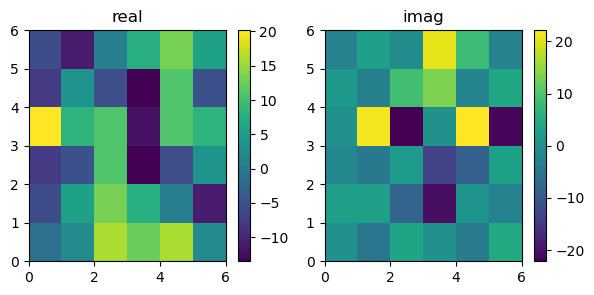

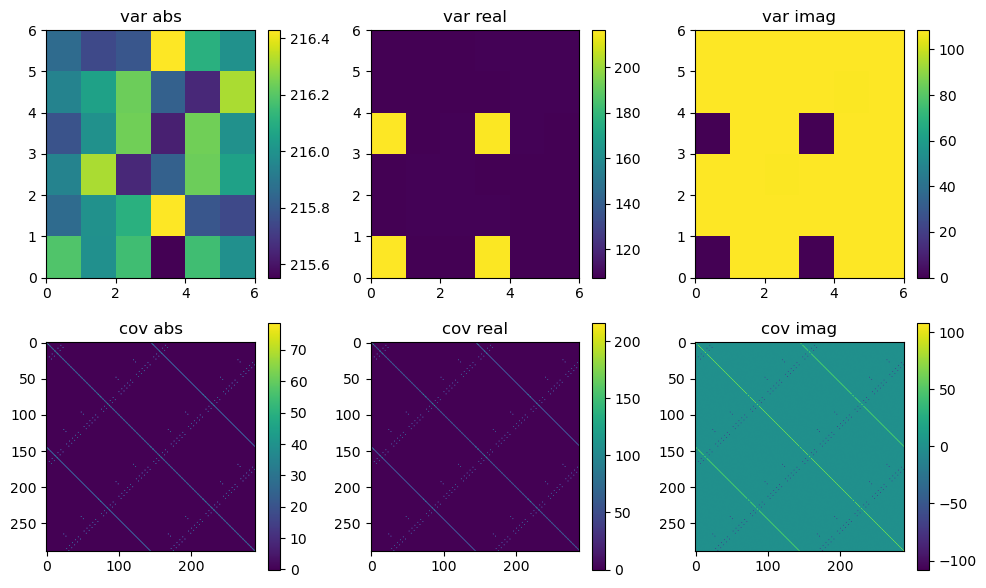

In [6]:
fourier = vmap(genrete_realx_gaussian_field_3d_k_mask)(spatial)
fourier *= jnp.array(size).prod()**.5
Cs_generate = plot_fourier(fourier, i_toplot)
assert_allclose(Cs_rfftn, Cs_generate, rtol=1e-5, atol=1)

# Reparam any Complex Gaussian

In [6]:
from montecosmo.bricks import lin_power_mesh, Planck18
from montecosmo.utils import rg2cgh, cgh2rg
from montecosmo.metrics import power_spectrum
import numpy as np
from jax import random as jr, numpy as jnp, vmap
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
n_rep = 10_000
a = 1.
cosmo = Planck18()
mesh_shape = 3*(32,)
box_shape = np.array([640,640,640])
norm = "forward"
std_mesh = lin_power_mesh(cosmo, mesh_shape, box_shape, a)
mu_mesh = jnp.fft.rfftn(jr.normal(jr.key(33), mesh_shape), norm=norm)

def ref_mesh_fn(rng):
    # seed_mesh = jr.normal(rng, mesh_shape)
    # mesh = jnp.fft.rfftn(seed_mesh, norm=norm)

    seed_mesh = jr.normal(rng, mesh_shape)
    mesh = rg2cgh(seed_mesh, norm=norm)

    mesh = std_mesh * mesh + mu_mesh
    # mesh = jnp.fft.irfftn(mesh, norm=norm)
    return mesh

ref_meshes = vmap(ref_mesh_fn)(jr.split(jr.key(0), n_rep))
ref_mean, ref_std = ref_meshes.mean(0), ref_meshes.std(0)

def our_mesh_fn(rng):
    seed_mesh = jr.normal(rng, mesh_shape)
    seed_mesh = seed_mesh * cgh2rg(std_mesh, norm=norm, amp=True) + cgh2rg(mu_mesh, norm=norm)
    
    mesh = rg2cgh(seed_mesh, norm=norm)
    # mesh = jnp.fft.irfftn(mesh, norm=norm)
    return mesh

our_meshes = vmap(our_mesh_fn)(jr.split(jr.key(0), n_rep))
our_mean, our_std = our_meshes.mean(0), our_meshes.std(0)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


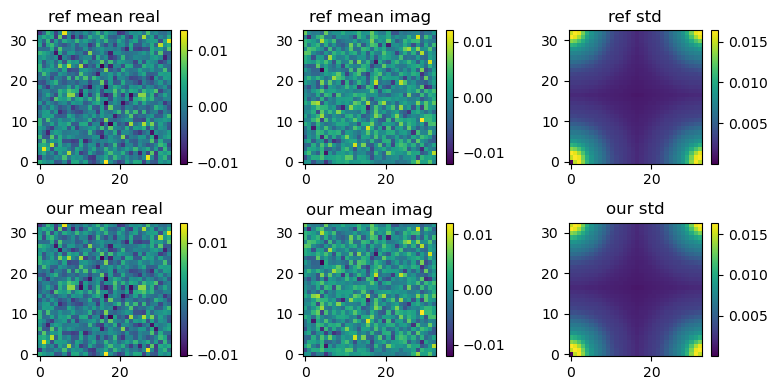

In [11]:
from montecosmo.plot import plot_mesh, plot_pk, plot_bivar
sli = 1
plt.figure(figsize=(8,4))
plt.subplot(231)
plot_mesh(ref_mean.real, sli=sli)
plt.colorbar(), plt.title("ref mean real")
plt.subplot(232)
plot_mesh(ref_mean.imag, sli=sli)
plt.colorbar(), plt.title("ref mean imag")
plt.subplot(233)
plot_mesh(ref_std, sli=sli)
plt.colorbar(), plt.title("ref std")

plt.subplot(234)
plot_mesh(our_mean.real, sli=sli)
plt.colorbar(), plt.title("our mean real")
plt.subplot(235)
plot_mesh(our_mean.imag, sli=sli)
plt.colorbar(), plt.title("our mean imag")
plt.subplot(236)
plot_mesh(our_std, sli=sli)
plt.colorbar(), plt.title("our std")
plt.tight_layout()

from numpy.testing import assert_allclose
tol = 1e-5
assert_allclose(our_mean, ref_mean, rtol=tol, atol=tol)
assert_allclose(our_std, ref_std, rtol=tol, atol=tol)

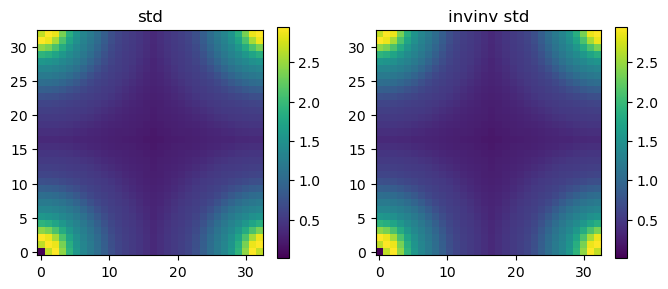

In [12]:
invinv = rg2cgh(cgh2rg(std_mesh, norm=norm, amp=True), norm=norm, amp=True)
sli = 1
plt.figure(figsize=(8,3))
plt.subplot(121)
plot_mesh(std_mesh, sli=sli)
plt.colorbar(), plt.title("std")
plt.subplot(122)
plot_mesh(invinv, sli=sli)
plt.colorbar(), plt.title("invinv std")

tol = 1e-7
assert_allclose(invinv, std_mesh, rtol=tol, atol=tol)

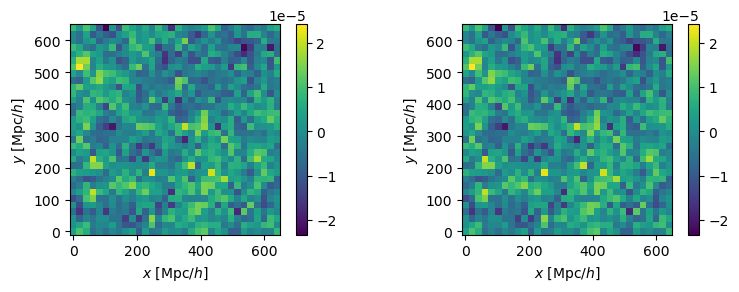

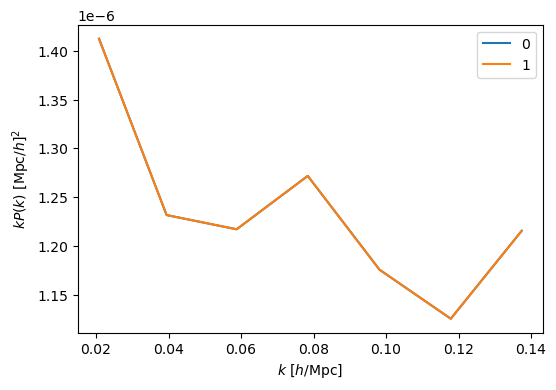

In [13]:
from montecosmo.plot import plot_mesh, plot_pk, plot_bivar
meshes = []
meshes.append(jnp.fft.irfftn(ref_meshes[0]))
meshes.append(jnp.fft.irfftn(our_meshes[0]))

plt.figure(figsize=(8, 3))
for i_plt, mesh in enumerate(meshes):
    plt.subplot(1,len(meshes),i_plt+1)
    plot_mesh(mesh, box_shape)
    plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(6, 4))
for i_plt, mesh in enumerate(meshes):
    kpk = power_spectrum(mesh, box_shape=box_shape, comp=False)
    plot_pk(*kpk, label=f"{i_plt}")
plt.legend()
plt.show()

# Gaussian Linear Model Posterior

In [70]:
from montecosmo.model import FieldLevelModel, default_config
from montecosmo.mcbench import Chains
config = {
          'mesh_shape':3 * (128,),
          'box_shape':3 * (640.,),
          'a_lpt':0.1,
          'a_obs':0.1,
          'lpt_order':1,
          'precond':0,
          'obs':'mesh'
          }
model = FieldLevelModel(**default_config | config)

truth = {'Omega_m': 0.31, 
        'sigma8': 0.81, 
        'b1': 1., 
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
model.obs_meshk = truth['obs']-1
init_params_ = jit(vmap(partial(model.init_model, base=True)))(jr.split(jr.key(43), 100))

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

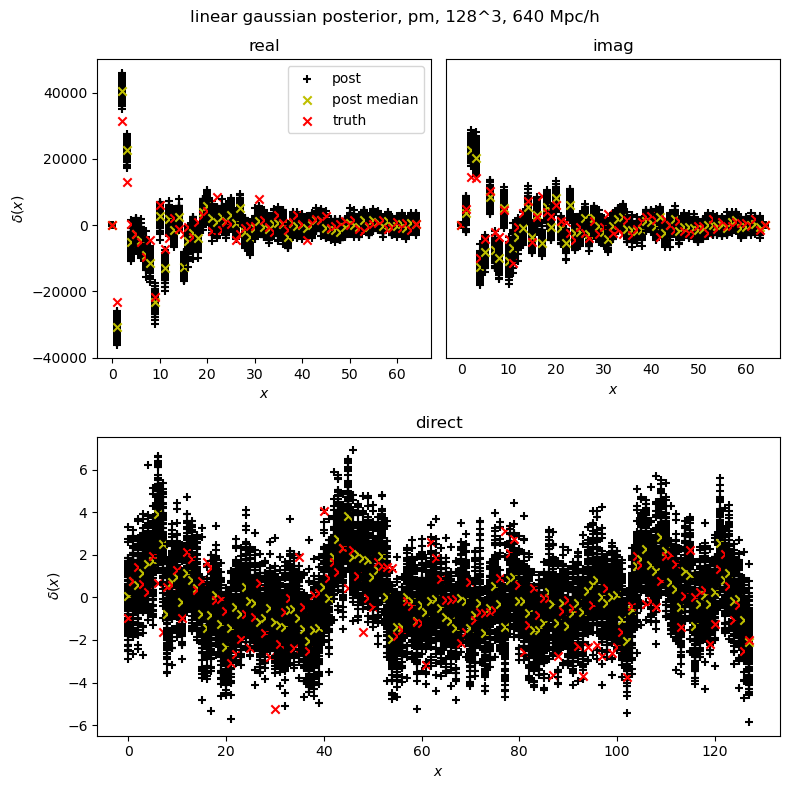

In [60]:
meshes = []
meshes_true = []
i_s = 0
i_st = 0
meshes.append(init_params_['init_mesh'][:,i_s,i_s,i_st:].real)
meshes_true.append(truth['init_mesh'][i_s,i_s,i_st:].real)
meshes.append(init_params_['init_mesh'][:,i_s,i_s,i_st:].imag)
meshes_true.append(truth['init_mesh'][i_s,i_s,i_st:].imag)
meshes.append(vmap(jnp.fft.irfftn)(init_params_['init_mesh'])[:,i_s,i_s,i_st:])
meshes_true.append(jnp.fft.irfftn(truth['init_mesh'])[i_s,i_s,i_st:])

plt.figure(figsize=(8,8))
labels = ['real', 'imag', 'direct']
for i_plt, (mesh, mesh_true) in enumerate(zip(meshes, meshes_true)):
    if i_plt == 0:
        plt.subplot(2,2,i_plt+1)
    elif i_plt == 1:
        plt.subplot(2,2,i_plt+1, sharey=plt.gca())
        plt.gca().tick_params(labelleft=False, length=0)
    elif i_plt == 2:
        plt.subplot(2,1,2)

    for i in range(mesh_true.shape[0]):
        plt.scatter(100*(i,), mesh[:,i], c='k', marker='+', label='post')
        plt.scatter(i, jnp.median(mesh[:,i]), c='y', marker='x', label='post median')
        plt.scatter(i, mesh_true[i], c='r', marker='x', label='truth')
        plt.legend() if i == 0 and i_plt == 0 else None
        plt.xlabel('$x$'), plt.ylabel('$\\delta(x)$') if i_plt==0 or i_plt==2 else None
        plt.title(labels[i_plt])
plt.suptitle('linear gaussian posterior, pm, 128^3, 640 Mpc/h')
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), "init_mesh_pm.svg")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

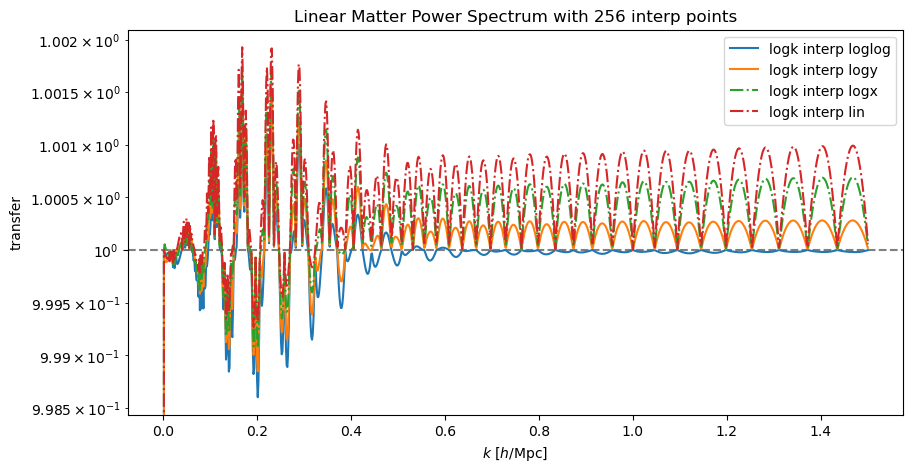

In [6]:
import jax_cosmo as jc
from montecosmo.bricks import Planck18
from montecosmo.plot import plot_pk, plot_trans

def lin_power_interp(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
     # equivalent to jnp.interp(..., left="extrapolate", right="extrapolate")
    return pk_fn

def lin_power_interp2(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp3(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp4(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp5(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    logpk = jnp.log(jc.power.linear_matter_power(cosmo, k, a=a))
    pk_fn = lambda x: jnp.exp(jnp.interp(x.reshape(-1), k, logpk, left=-jnp.inf, right=-jnp.inf)).reshape(x.shape)
    return pk_fn

def lin_power_interp6(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp7(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.linspace(0, 10, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(x.reshape(-1), k, pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp8(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(jnp.log(x.reshape(-1)), jnp.log(k), pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

def lin_power_interp9(cosmo=Planck18(), a=1., n_interp=256):
    k = jnp.logspace(-4, 1, n_interp)
    pk = jc.power.linear_matter_power(cosmo, k, a=a)
    pk_fn = lambda x: jnp.interp(x.reshape(-1), k, pk, left=0., right=0.).reshape(x.shape)
    return pk_fn

n_interp = 256
k_values = jnp.logspace(-4.5, 1, 100)
k_values = jnp.linspace(0, 1.5, 1000)
cosmo = Planck18()
pk_fn0 = lambda k: jc.power.linear_matter_power(cosmo, k)
pk_fn1 = lin_power_interp(cosmo, n_interp=n_interp)
pk_fn2 = lin_power_interp2(cosmo, n_interp=n_interp)
pk_fn3 = lin_power_interp3(cosmo, n_interp=n_interp)
pk_fn4 = lin_power_interp4(cosmo, n_interp=n_interp)
pk_fn5 = lin_power_interp5(cosmo, n_interp=n_interp)
pk_fn6 = lin_power_interp6(cosmo, n_interp=n_interp)
pk_fn7 = lin_power_interp7(cosmo, n_interp=n_interp)
pk_fn8 = lin_power_interp8(cosmo, n_interp=n_interp)
pk_fn9 = lin_power_interp9(cosmo, n_interp=n_interp)

pk_values0 = pk_fn0(k_values)
pk_values1 = pk_fn1(k_values)
pk_values2 = pk_fn2(k_values)
pk_values3 = pk_fn3(k_values)
pk_values4 = pk_fn4(k_values)
pk_values5 = pk_fn5(k_values)
pk_values6 = pk_fn6(k_values)
pk_values7 = pk_fn7(k_values)
pk_values8 = pk_fn8(k_values)
pk_values9 = pk_fn9(k_values)
pk_values0 = jnp.where(pk_values0 == 0., 1., pk_values0)
ks = k_values

plt.figure(figsize=(10, 5))
log = False
# plot_pk(k_values, pk_values0, log=log, label='lin_mat_pow')
# plot_pk(ks, pk_values1, '+:', log=log, label='jc_interp')
# plot_pk(ks, pk_values2, 'x:', log=log, label='k interp loglog')
# plot_pk(ks, pk_values3, '*:', log=log, label='k interp logy')
# plot_pk(ks, pk_values4, 'x', log=log, label='logk interp loglog')
# plot_pk(ks, pk_values5, '*:', log=log, label='logk interp logy')

# plot_trans(ks[1:], ((pk_values1/pk_values0)**.5)[1:], '', log=log, label='jc_interp')
# plot_trans(ks, (pk_values2/pk_values0)**.5, ':', log=log, label='k interp loglog')
# plot_trans(ks, (pk_values3/pk_values0)**.5, ':', log=log, label='k interp logy')
plot_trans(ks, (pk_values4/pk_values0)**.5, '', log=log, label='logk interp loglog')
plot_trans(ks, (pk_values5/pk_values0)**.5, '', log=log, label='logk interp logy')
# plot_trans(ks, (pk_values6/pk_values0)**.5, '--', log=log, label='k interp logx')
# plot_trans(ks, (pk_values7/pk_values0)**.5, '--', log=log, label='k interp lin')
plot_trans(ks, (pk_values8/pk_values0)**.5, '-.', log=log, label='logk interp logx')
plot_trans(ks, (pk_values9/pk_values0)**.5, '-.', log=log, label='logk interp lin')
plt.hlines(1, *plt.xlim(plt.xlim()), color='k', linestyle='--', alpha=.5, zorder=-1)
plt.legend()
plt.title(f'Linear Matter Power Spectrum with {n_interp} interp points')
plt.show()

In [71]:
kpptcs = vmap(lambda x: model.pktranscoh(jnp.fft.irfftn(truth['init_mesh']), jnp.fft.irfftn(x)))(init_params_['init_mesh'])
jnp.shape(jnp.array(kpptcs))

(5, 100, 31)

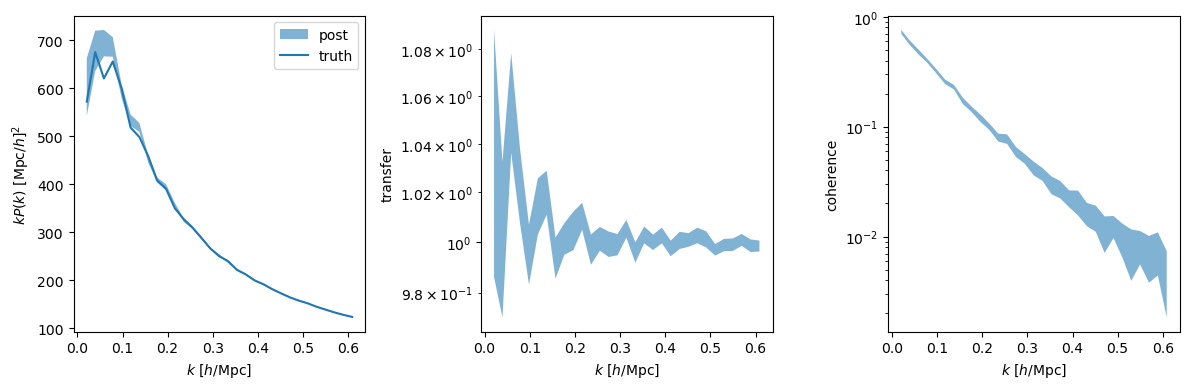

In [74]:
from montecosmo.plot import plot_pktranscoh, plot_pk
log = False
plt.figure(figsize=(12,4))
ks, pk0, pk1, trans, coh = jnp.array(kpptcs)
plot_pktranscoh(ks, pk1, trans, coh, log=log, fill=.68, label='post')
plt.subplot(1,3,1)
plot_pk(ks[0], pk0[0], log=log, label=f"truth")
plt.legend()
plt.tight_layout()

In [14]:
from montecosmo.model import FieldLevelModel, default_config
kpptcss = []
a_obss = [0.1, 0.5, 1.]

for a_obs in a_obss:
    config = {
            'mesh_shape':3 * (128,),
            'box_shape':3 * (640.,),
            'a_lpt':0.1,
            'a_obs':a_obs,
            'lpt_order':1,
            'precond':0,
            'obs':'mesh'
            }
    model = FieldLevelModel(**default_config | config)

    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    model.obs_meshk = truth['obs']-1
    init_params_ = jit(vmap(partial(model.init_model, base=True)))(jr.split(jr.key(43), 100))

    kpptcs = vmap(lambda x: model.pktranscoh(jnp.fft.irfftn(truth['init_mesh']), jnp.fft.irfftn(x)))(init_params_['init_mesh'])
    print(jnp.shape(jnp.array(kpptcs)))
    kpptcss.append(kpptcs)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

(5, 100, 31)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

n_solvsteps: 4


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(5, 100, 31)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

n_solvsteps: 5


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


(5, 100, 31)


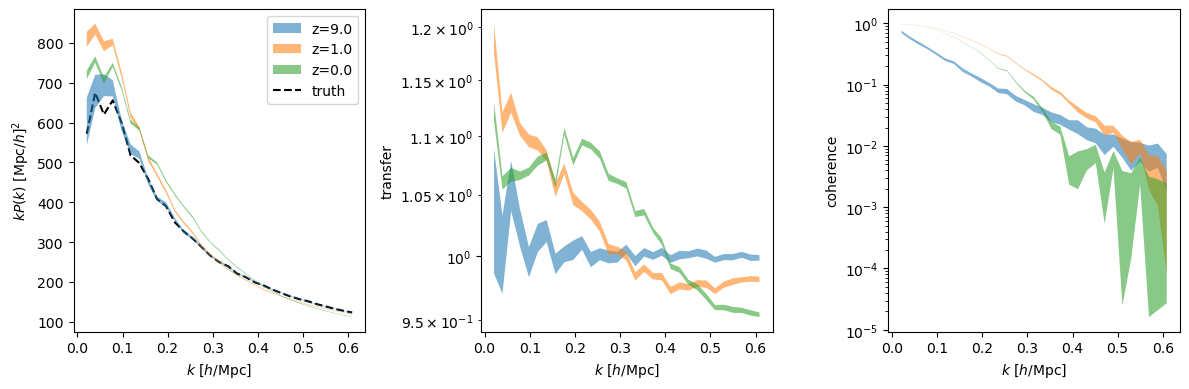

In [15]:
from montecosmo.plot import plot_pktranscoh, plot_pk
log = False
plt.figure(figsize=(12,4))
for i_plt, kpptcs in enumerate(kpptcss):
    ks, pk0, pk1, trans, coh = jnp.array(kpptcs)
    plot_pktranscoh(ks, pk1, trans, coh, log=log, fill=.68, label=f"z={1/a_obss[i_plt]-1:.1f}")
plt.subplot(1,3,1)
plot_pk(ks[0], pk0[0], 'k--', log=log, label=f"truth", zorder=-1)
plt.legend()
plt.tight_layout()